<a href="https://colab.research.google.com/github/daniellegruber/RL-Brain-Trajectories/blob/main/Master_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP rest and task dataset
###  **(Modified from NMA HCP dataset)**

original colab notebook:  [link](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/fMRI/load_hcp_task_with_behaviour.ipynb) 

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from google.colab import drive

### Set up directory

In [ ]:
# todo: save (group-level) state vectors 
# Directory
from google.colab import drive

drive.mount('/content/gdrive')
parent_dir = "gdrive/MyDrive"
child_dir = "Optimal Brain Trajectories"
save_dir = os.path.join(parent_dir, child_dir)
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
if not os.path.exists(os.path.join(save_dir,'HCP-data')):
  os.mkdir(os.path.join(save_dir,'HCP-data'))

Mounted at /content/gdrive


In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}



> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading Task data



In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/2y3fw/download
  !tar -xzf $fname -C $HCP_DIR --strip-components=1


subjects = np.loadtxt(os.path.join(HCP_DIR,'subjects_list.txt'),dtype='str')


# Downloading REST data
first test out iterating over rest data and calculating the FC matrix

In [ ]:
# Found this link  from googling
# This cell takes pretty long to run!
fname = "hcp_rest.tgz"
REST_DIR = './hcp_rest'
if not os.path.isdir(REST_DIR):
  os.mkdir(REST_DIR)

if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download
  !tar -xzf $fname -C $REST_DIR --strip-components=1
  
# !tar -xzf $fname -C 'hcp_rest' --strip-components=1

In [ ]:
# rest subjects have 4 sessions each (bold1, bold2, bold3, bold4)

!ls ./hcp_rest/subjects/118/timeseries

bold1_Atlas_MSMAll_Glasser360Cortical.npy
bold2_Atlas_MSMAll_Glasser360Cortical.npy
bold3_Atlas_MSMAll_Glasser360Cortical.npy
bold4_Atlas_MSMAll_Glasser360Cortical.npy


In [ ]:
thedir = './hcp_rest/subjects/'
subjlist = [name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name))]

In [ ]:
len(subjlist)

339

In [ ]:
rest_subj_dir = "./hcp_rest/subjects/"
prefix = "/timeseries/bold1_Atlas_MSMAll_Glasser360Cortical.npy"

corrmats = np.empty([360, 360, len(subjlist)])

for idx, subj in enumerate(subjlist):
  ts = np.load(rest_subj_dir+subj+prefix)
  corrmats[:,:,idx] = np.corrcoef(ts)

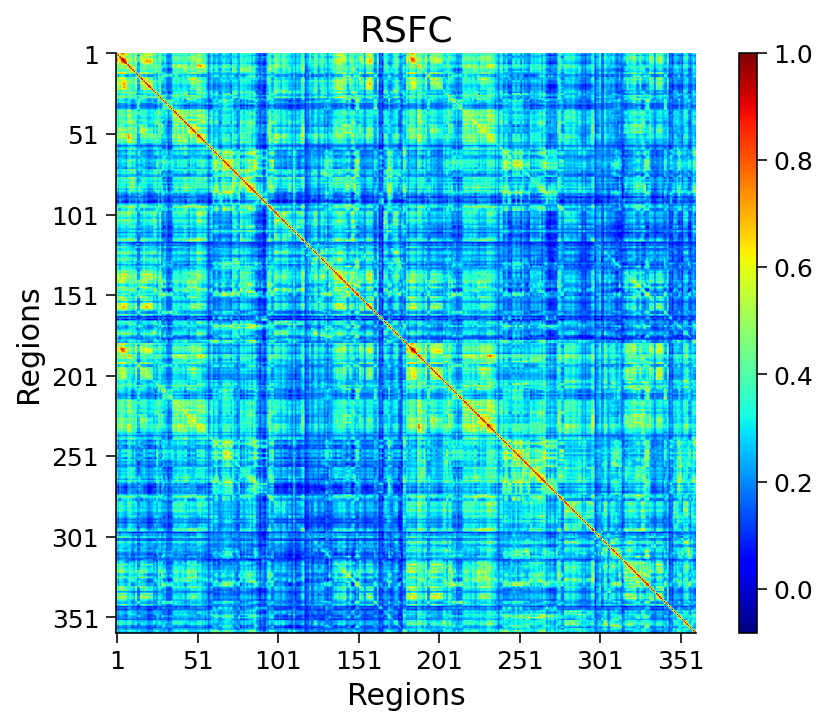

In [ ]:
RSFC = np.mean(corrmats,axis=2)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

num_ROI = RSFC.shape[0]

plt.title('RSFC')
plt.xlabel('Regions')
plt.xticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))
plt.ylabel('Regions')
plt.yticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))

cmap = plt.cm.jet
plt.imshow(RSFC, cmap=cmap, origin='upper')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.3)
plt.colorbar(ax=ax,cax=cax)

### Functions for creating adjacency matrices

In [ ]:
def RSFC_to_binary_adj(RSFC, thresh):
  adj_matrix = np.greater(RSFC, thresh * np.ones((RSFC.shape)))

  fig = plt.figure(figsize=(6, 6))
  plt.imshow(adj_matrix, interpolation='none', origin='upper')
  plt.title('Adjacency Matrix')
  plt.xlabel('Regions')
  plt.xticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))
  plt.ylabel('Regions')
  plt.yticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))

  return adj_matrix

#A = RSFC_to_binary_adj(RSFC, 0.45)

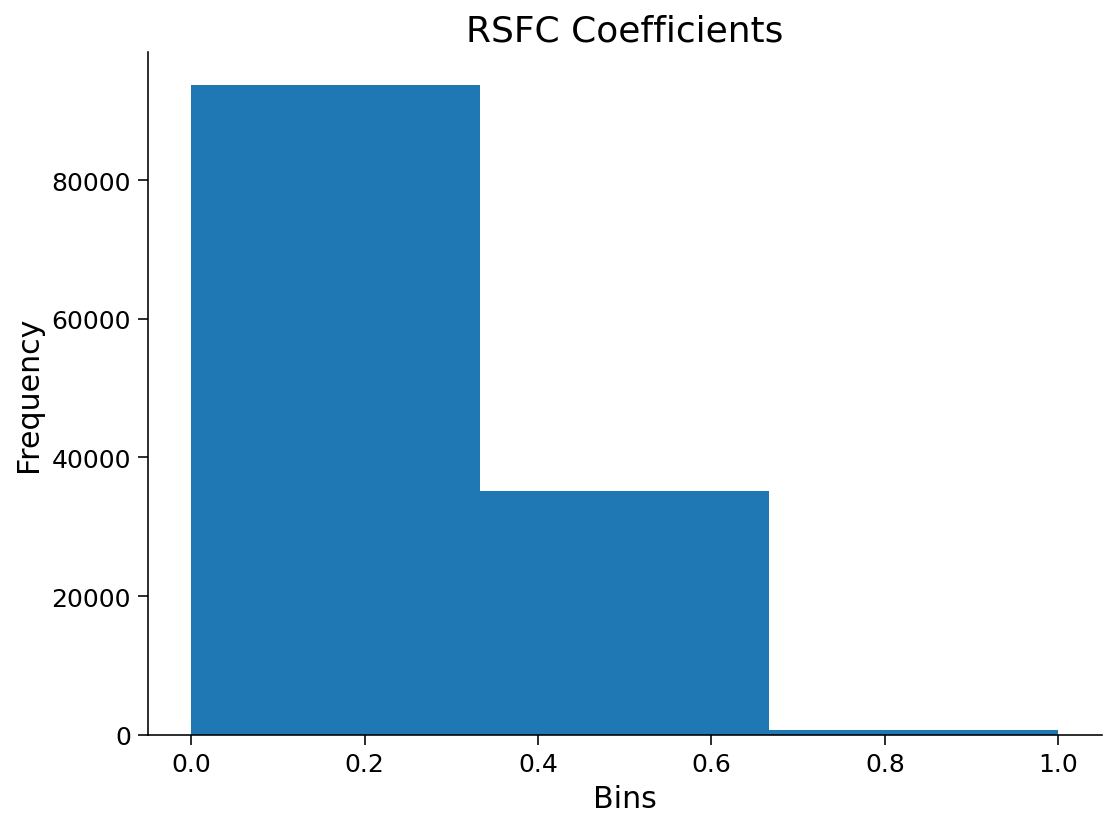

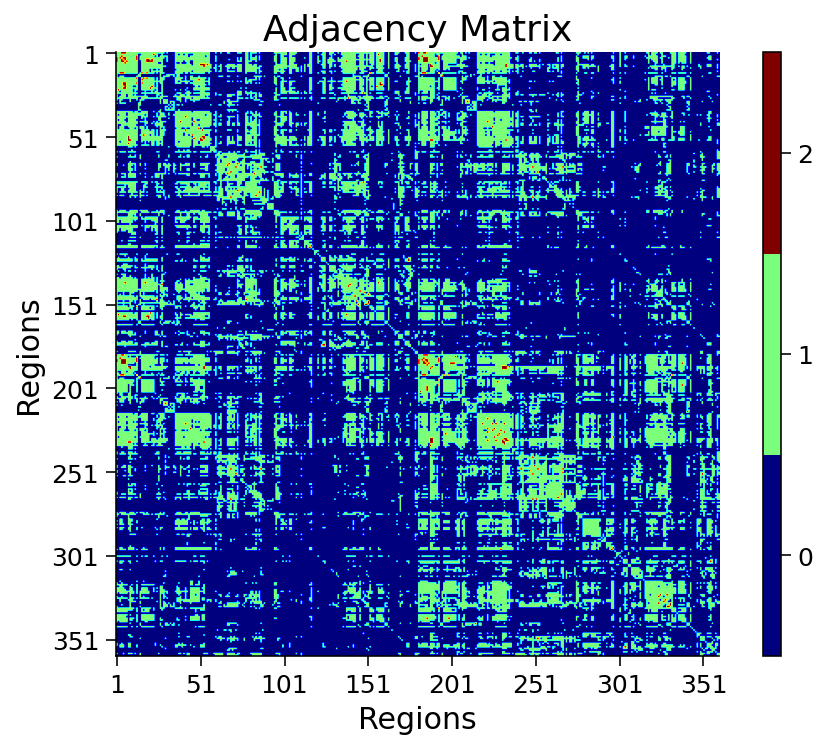

In [ ]:
def RSFC_to_binned_adj(RSFC, num_bins):

  adj_matrix = RSFC
  # Zero out negative coefficients 
  adj_matrix[np.less(adj_matrix,np.zeros(RSFC.shape))] = 0

  # Create bins         
  #bins = np.linspace(0,1,num_bins)
  #for b in range(num_bins-1):
  #  idx = np.greater(adj_matrix, bins[b] * np.ones(RSFC.shape)) & np.less(adj_matrix, bins[b+1] * np.ones(RSFC.shape))
  #  adj_matrix[idx] = b+1

  bins = np.linspace(0,1,num_bins+1)

  # Histogram to visualize how RSFC coefficients fall into bins
  plt.hist(RSFC.flatten('C'), bins)
  plt.title('RSFC Coefficients')
  plt.xlabel('Bins')
  plt.ylabel('Frequency')

  for b in range(num_bins):
    idx = np.greater(adj_matrix, bins[b] * np.ones(RSFC.shape)) & np.less(adj_matrix, bins[b+1] * np.ones(RSFC.shape))
    adj_matrix[idx] = b


  # Plot figure
  fig, ax = plt.subplots(1, 1, figsize=(6, 6))
  plt.title('Adjacency Matrix')
  plt.xlabel('Regions')
  plt.xticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))
  plt.ylabel('Regions')
  plt.yticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))

  cmap = plt.cm.jet
  cmaplist = [cmap(i) for i in range(cmap.N)]

  cmap = mpl.colors.LinearSegmentedColormap.from_list(
      'Custom cmap', cmaplist, cmap.N)

  bounds = np.arange(len(np.unique(adj_matrix))+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  

  plt.imshow(adj_matrix, cmap=cmap, origin='upper')


  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0.3)
  cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, 
                                 spacing='proportional', ticks=bounds-0.5, boundaries=bounds, format='%1i')

  return adj_matrix

A = RSFC_to_binned_adj(RSFC, 3)

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)
np.save(os.path.join(save_dir, 'HCP-data', 'networks'), region_info['network'])

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment 
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [ ]:
!ls hcp/subjects/100307/MOTOR/tfMRI_MOTOR_LR/EVs

cue.txt  lf.txt  lh.txt  rf.txt  rh.txt  Sync.txt  t.txt


In [ ]:
np.loadtxt('hcp/subjects/100307/MOTOR/tfMRI_MOTOR_LR/EVs/cue.txt')

array([[  8.05 ,   3.   ,   1.   ],
       [ 23.164,   3.   ,   1.   ],
       [ 38.291,   3.   ,   1.   ],
       [ 53.419,   3.   ,   1.   ],
       [ 68.546,   3.   ,   1.   ],
       [ 98.667,   3.   ,   1.   ],
       [113.794,   3.   ,   1.   ],
       [128.921,   3.   ,   1.   ],
       [159.043,   3.   ,   1.   ],
       [174.17 ,   3.   ,   1.   ]])

In [ ]:
my_exp  = 'MOTOR'
my_subj = subjects[1]
my_run  = 1

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
print(data.shape)

(360, 284)


In [ ]:
data

array([[ -61.03429189, -181.84161624, -138.64487302, ...,  -12.54664038,
         -48.02073604,   -9.49748901],
       [-225.4544832 , -146.51912907, -192.87718057, ...,   11.63520635,
          13.26624562,   -5.84291094],
       [ 106.73425935,   69.41979034,   80.03682699, ..., -104.63769187,
         -96.50232284,  -97.84024523],
       ...,
       [ -77.8548603 ,  -90.65374101, -123.40396637, ...,  -44.87684047,
          16.20819559,   66.61361926],
       [-172.92711419,  -69.92377252, -140.92620629, ...,  -16.72709435,
           2.67853766,  -69.83517236],
       [ -69.36702197,   23.97169368,  -17.61993482, ..., -190.29524463,
         -90.64136869,  -37.5434262 ]])

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions. 

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [ ]:
evs[0]

[array([ 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115]),
 array([246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262])]

In [ ]:
# we need a little function that averages all frames from any given condition

def average_frames(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)


lf_activity = average_frames(data, evs, my_exp, 'lf')
rf_activity = average_frames(data, evs, my_exp, 'rf')
contrast    = lf_activity-rf_activity   # difference between left and right hand movement

cue_activity = average_frames(data, evs, my_exp, 'cue')


In [ ]:
np.array(cue_activity).reshape(1,-1).shape

(1, 360)

In [ ]:
#iterate over subjects and create Motor task matrix 

my_exp  = 'MOTOR' # testing with motor task for now
my_run  = 1       # use first run

all_subj_cue = np.empty([N_SUBJECTS, N_PARCELS])
all_subj_lh  = np.empty([N_SUBJECTS, N_PARCELS])
all_subj_rh  = np.empty([N_SUBJECTS, N_PARCELS])
all_subj_lf  = np.empty([N_SUBJECTS, N_PARCELS])
all_subj_rf  = np.empty([N_SUBJECTS, N_PARCELS])
all_subj_t   = np.empty([N_SUBJECTS, N_PARCELS])

for idx, subject in enumerate(subjects):
  my_subj = subject
  data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
  evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)

  # cue
  all_subj_cue[idx,:] = average_frames(data, evs, my_exp, 'cue')
  
  # hand
  all_subj_lh[idx,:] = average_frames(data, evs, my_exp, 'lh')
  all_subj_rh[idx,:] = average_frames(data, evs, my_exp, 'rh')

  # foot
  all_subj_lf[idx,:] = average_frames(data, evs, my_exp, 'lf')
  all_subj_rf[idx,:] = average_frames(data, evs, my_exp, 'rf')
 
  # tongue
  all_subj_t[idx,:]  = average_frames(data, evs, my_exp, 't')


initial_state_cue = np.mean(all_subj_cue, axis=0)
target_state_lh   = np.mean(all_subj_lh, axis=0)
target_state_rh   = np.mean(all_subj_rh, axis=0)
target_state_lf   = np.mean(all_subj_lf, axis=0)
target_state_rf   = np.mean(all_subj_rf, axis=0)
target_state_t    = np.mean(all_subj_t, axis=0)


In [ ]:
np.save(os.path.join(save_dir, 'HCP-data', 'initial_state_cue'), initial_state_cue)
np.save(os.path.join(save_dir, 'HCP-data', 'target_state_lh'),  target_state_lh)
np.save(os.path.join(save_dir, 'HCP-data', 'target_state_rh'),  target_state_rh)
np.save(os.path.join(save_dir, 'HCP-data', 'target_state_lf'),  target_state_lf)
np.save(os.path.join(save_dir, 'HCP-data', 'target_state_rf'),  target_state_rf)
np.save(os.path.join(save_dir, 'HCP-data', 'target_state_t'),   target_state_t)

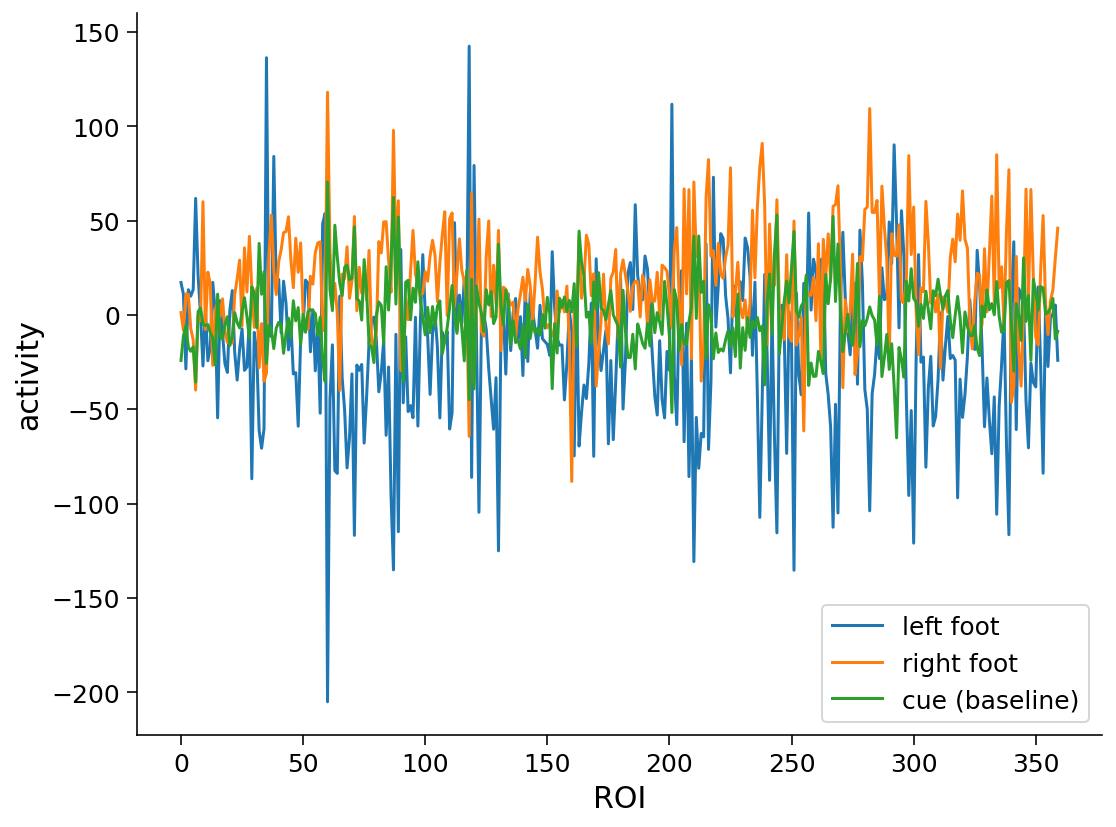

In [ ]:
# Plot subject-level activity in each ROI for both foot conditions
plt.plot(lf_activity,label='left foot')
plt.plot(rf_activity,label='right foot')

# Plot que activity
plt.plot(cue_activity,label='cue (baseline)')


plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

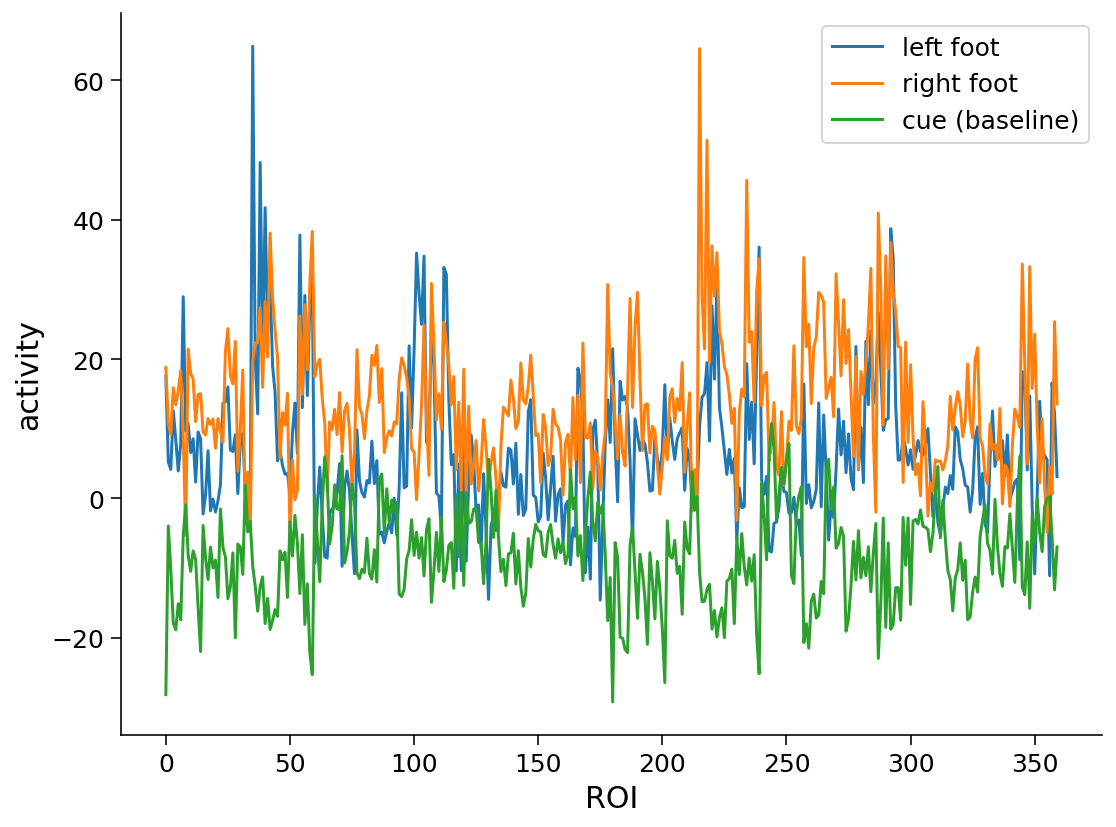

In [ ]:
# Plot group-level activity in each ROI for both foot conditions
plt.plot(target_state_lf,label='left foot')region_info['network']
plt.plot(target_state_rf,label='right foot')

# Plot que activity
plt.plot(initial_state_cue,label='cue (baseline)')


plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





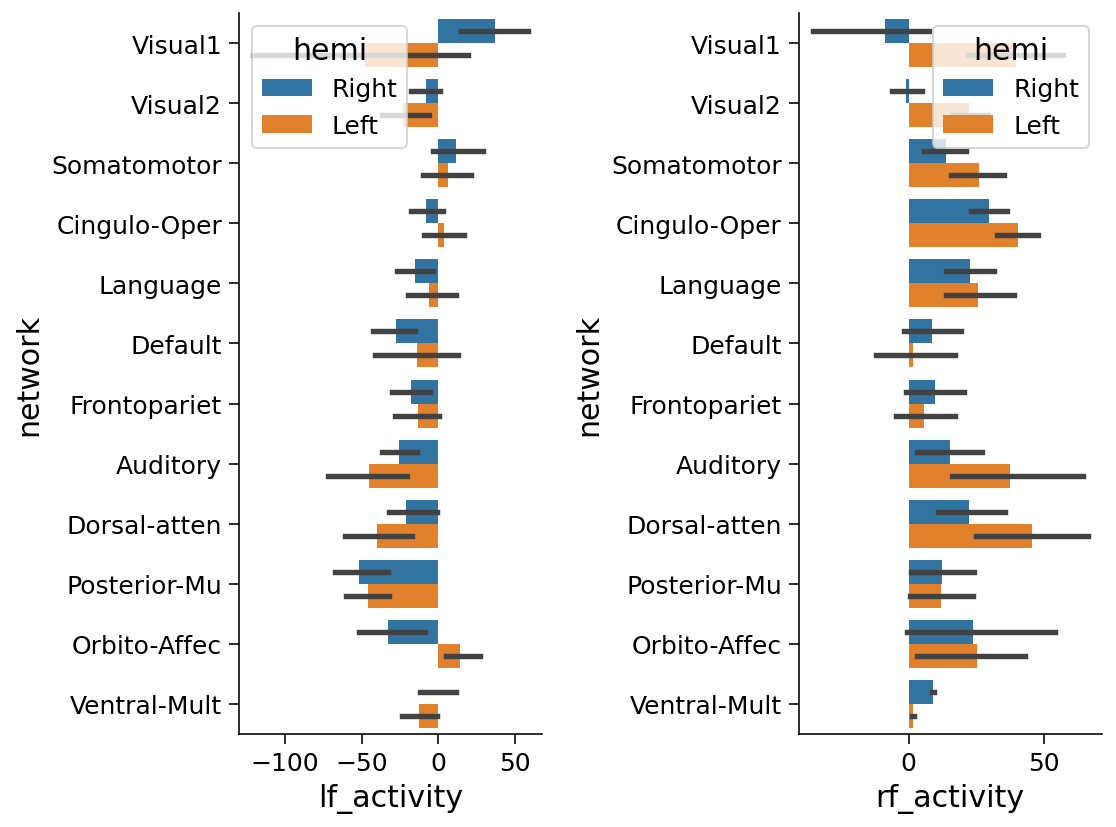

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'lf_activity' : lf_activity,
                   'rf_activity' : rf_activity,
                   'network'     : region_info['network'],
                   'hemi'        : region_info['hemi']})

fig,(ax1,ax2) = plt.subplots(1,2)
sns.barplot(y='network', x='lf_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rf_activity', data=df, hue='hemi',ax=ax2)




You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans). 


Let us boost thee stats by averaging across all subjects and runs. 

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'lf')
    rf_activity = average_frames(data, evs, my_exp, 'rf')

    contrast    = lf_activity-rf_activity
    group_contrast        += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject



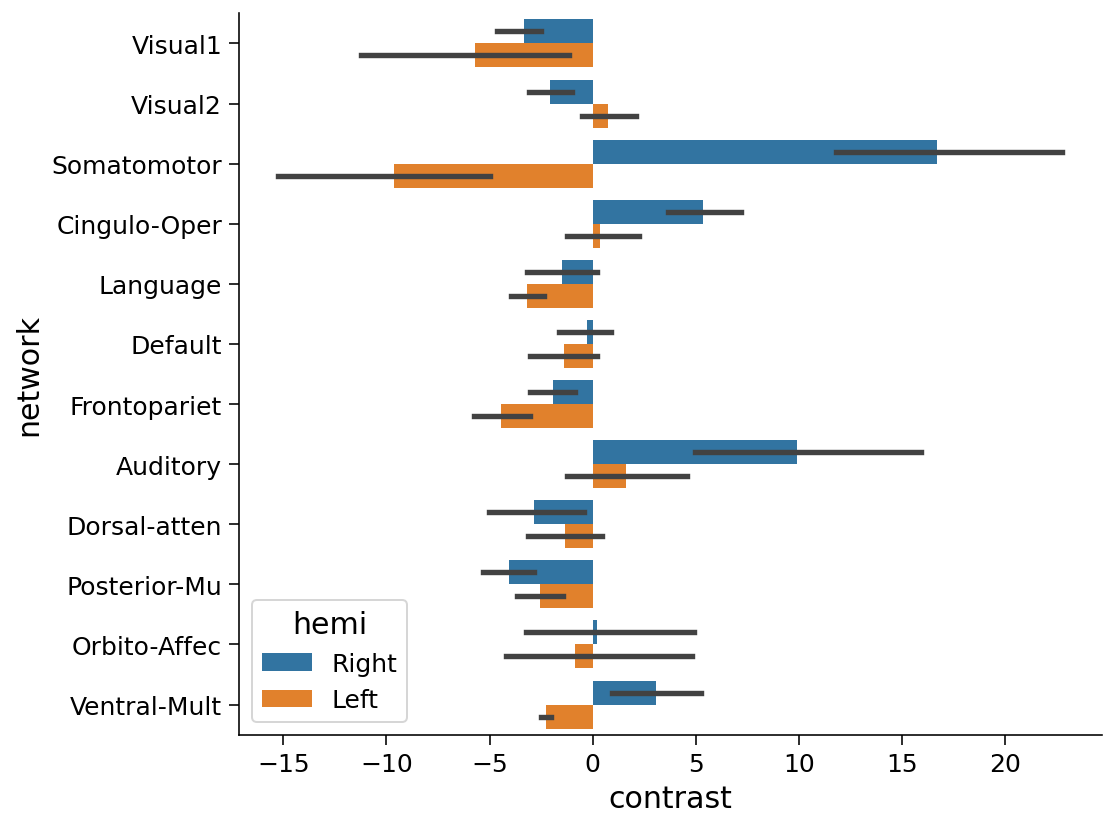

In [ ]:

df = pd.DataFrame({'contrast':group_contrast,'network':region_info['network'],'hemi':region_info['hemi']})
# we will plot the left foot minus right foot contrast so we only need one plot
sns.barplot(y='network', x='contrast', data=df, hue='hemi')




# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:

# This uses the nilearn package
!pip install nilearn --quiet
from nilearn import plotting, datasets

# NMA provides an atlas 
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download
with np.load(fname) as dobj:
  atlas = dict(**dobj)

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
np.unique(region_info['network'])

array(['Auditory', 'Cingulo-Oper', 'Default', 'Dorsal-atten',
       'Frontopariet', 'Language', 'Orbito-Affec', 'Posterior-Mu',
       'Somatomotor', 'Ventral-Mult', 'Visual1', 'Visual2'], dtype='<U12')

In [ ]:
#print(region_info)
default_ROI = np.where(region_info['network'] == 'Default')
print(default_ROI[0])
somatomotor_ROI = np.where(region_info['network'] == 'Somatomotor')
print(somatomotor_ROI[0])
print(np.concatenate((default_ROI[0],somatomotor_ROI[0]),axis=0))

{'name': ['R_V1', 'R_MST', 'R_V6', 'R_V2', 'R_V3', 'R_V4', 'R_V8', 'R_4', 'R_3b', 'R_FEF', 'R_PEF', 'R_55b', 'R_V3A', 'R_RSC', 'R_POS2', 'R_V7', 'R_IPS1', 'R_FFC', 'R_V3B', 'R_LO1', 'R_LO2', 'R_PIT', 'R_MT', 'R_A1', 'R_PSL', 'R_SFL', 'R_PCV', 'R_STV', 'R_7Pm', 'R_7m', 'R_POS1', 'R_23d', 'R_v23ab', 'R_d23ab', 'R_31pv', 'R_5m', 'R_5mv', 'R_23c', 'R_5L', 'R_24dd', 'R_24dv', 'R_7AL', 'R_SCEF', 'R_6ma', 'R_7Am', 'R_7PL', 'R_7PC', 'R_LIPv', 'R_VIP', 'R_MIP', 'R_1', 'R_2', 'R_3a', 'R_6d', 'R_6mp', 'R_6v', 'R_p24pr', 'R_33pr', 'R_a24pr', 'R_p32pr', 'R_a24', 'R_d32', 'R_8BM', 'R_p32', 'R_10r', 'R_47m', 'R_8Av', 'R_8Ad', 'R_9m', 'R_8BL', 'R_9p', 'R_10d', 'R_8C', 'R_44', 'R_45', 'R_47l', 'R_a47r', 'R_6r', 'R_IFJa', 'R_IFJp', 'R_IFSp', 'R_IFSa', 'R_p9-46v', 'R_46', 'R_a9-46v', 'R_9-46d', 'R_9a', 'R_10v', 'R_a10p', 'R_10pp', 'R_11l', 'R_13l', 'R_OFC', 'R_47s', 'R_LIPd', 'R_6a', 'R_i6-8', 'R_s6-8', 'R_43', 'R_OP4', 'R_OP1', 'R_OP2-3', 'R_52', 'R_RI', 'R_PFcm', 'R_PoI2', 'R_TA2', 'R_FOP4', 'R_MI', 'R